In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
#Kd : dissociation constant in hill equation

Hill binding ratio function
defined as
$Y = \frac{[L]^n}{[L]^n + Kd}$

In [3]:
def hill(ligand, binding_number, Kd):
    return (ligand)**binding_number / ((ligand)**binding_number + Kd)

Text(0.5, 1.0, 'hill model')

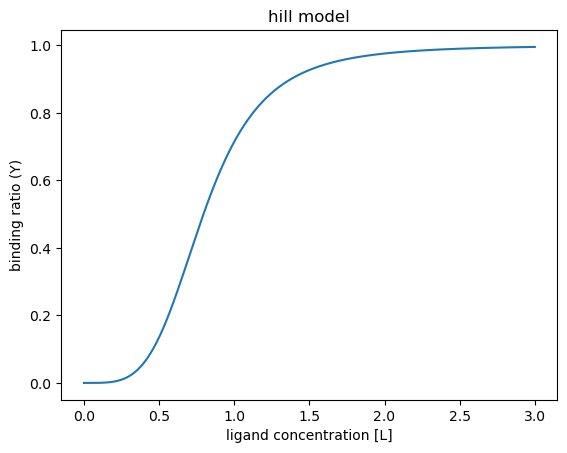

In [4]:
plt.plot(np.linspace(0,3,1000), hill(np.linspace(0,3,1000), 4, 0.4))
plt.xlabel("ligand concentration [L]")
plt.ylabel("binding ratio (Y)")
plt.title("hill model")

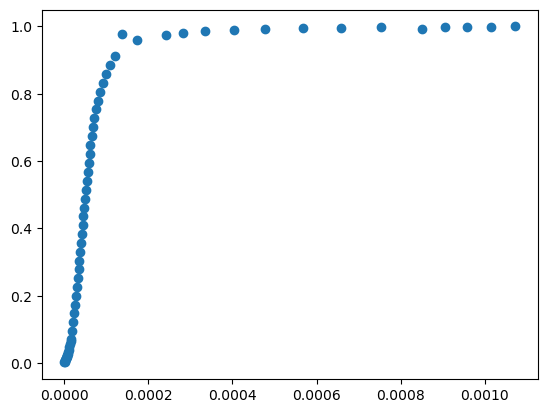

In [5]:
#real data from Winslow et al., 1977

oxygen = np.array([0.32, 0.81, 1.32, 1.82, 2.24, 2.68, 3.09, 3.49, 3.84, 4.22, 4.87, 5.52, 6.11, 7.11, 8.00, 8.77, 9.21, 11.20, 12.61, 14.02, 15.26, 16.59, 17.75, 18.83, 19.83, 20.91, 22.07, 23.15, 24.14, 25.39, 26.39, 27.38, 28.63, 29.87, 31.12, 32.53, 33.85, 35.10, 36.10, 38.17, 39.91, 41.74, 43.81, 46.30, 49.79, 53.44, 57.42, 62.82, 69.71, 80.16, 100.91, 140.48, 163.35, 194.66, 233.99, 277.34, 328.72, 381.30, 436.29, 492.88, 524.59, 555.89, 589.21, 622.12]) / 5.8e5
saturation = np.array([0.0016, 0.0040, 0.0064, 0.0088, 0.0112, 0.0136, 0.0161, 0.0185, 0.0209, 0.0233, 0.0281, 0.0329, 0.0376, 0.0472, 0.0566, 0.0660, 0.0701, 0.0958, 0.1217, 0.1476, 0.1736, 0.1996, 0.2256, 0.2517, 0.2779, 0.3041, 0.3302, 0.3565, 0.3828, 0.4090, 0.4354, 0.4618, 0.4882, 0.5146, 0.5410, 0.5675, 0.5940, 0.6206, 0.6471, 0.6737, 0.7002, 0.7268, 0.7534, 0.7800, 0.8064, 0.8329, 0.8593, 0.8855, 0.9116, 0.9770, 0.9609, 0.9758, 0.9815, 0.9860, 0.9895, 0.9924, 0.9944, 0.9962, 0.9978, 0.9921, 0.9995, 0.9998, 0.9999, 1.0000])

plt.scatter(oxygen, saturation)

Adair-Klotz Equation for Binding\
$Y = \frac{1}{n} \frac{\sum_{i=1}^{n}i[L]^{i}\prod_{j=1}^{i}Kj}{1 + \sum_{i=1}^{n}[L]^{i}\prod_{j=1}^{i}Kj}$

In [6]:
def product_termk(Ka_array, k):
    if k < 1:
        return 1.0
    return np.prod(Ka_array[:k]) #Ka_array에 있는 모든 값을 곱해서 되돌려줌.
    
def denominatork(L, n, Ka_array):
    return 1.0 + np.sum((L**i) * product_termk(Ka_array, i) for i in range(1, n+1)) #1부터 n까지 sum 해서 되돌려줌

def numeratork(L, n, Ka_array):
    return np.sum(j * (L**j) * product_termk(Ka_array, j) for j in range(1,n+1))

def Klotz_Adair(L, n, Ka_array):
    L = np.asarray(L, dtype = float)
    Ka_array = np.asarray(Ka_array, dtype = float)
    result = numeratork(L, n, Ka_array) / denominatork(L, n, Ka_array)
    return result / n

Using Non Linear Least Square Fit\
(cf. MWC model is only available when T, R state is clear. But what I want to model is not just for Hb, but for many kinds of proteins.)

success: True `ftol` termination condition is satisfied.
K1 = 21282.8  (M^-1)
K2 = 5960.53  (M^-1)
K3 = 131239  (M^-1)
K4 = 25492.5  (M^-1)
K5 = 0.735745  (M^-1)
K6 = 1e+08  (M^-1)
K7 = 57154.8  (M^-1)
R^2 = 0.9998
AIC=-654.86, AICc=-652.86, BIC=-639.75


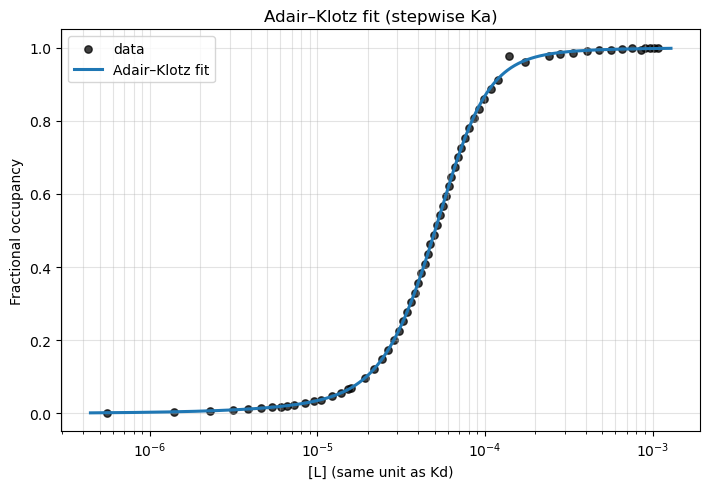

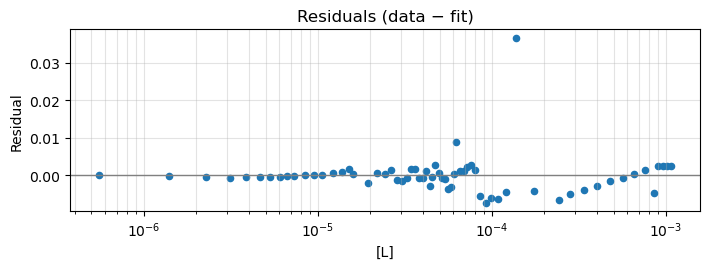

In [7]:
#Adair-Klotz Model
# Adair–Klotz: fit stepwise Ka1..Kan  (unit: L must match Ka^-1; e.g., M if Ka in M^-1)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

n = 7

# ===== 모델 =====
def adair_klotz_vec(L, Ka_array, per_site=True):
    """Adair–Klotz with stepwise Ka = [K1..Kn]. Return Y (0..1) if per_site, else ν (0..n)."""
    L = np.asarray(L, dtype=float)
    K = np.asarray(Ka_array, dtype=float)
    assert K.size == n, "len(Ka_array) must equal n"
    beta = np.cumprod(K)                     # β_i
    i = np.arange(1, n+1, dtype=float)
    Li = L[..., None] ** i[None, :]          # L^i
    terms = Li * beta[None, :]               # β_i L^i
    denom = 1.0 + terms.sum(axis=-1)
    numer = (i * terms).sum(axis=-1)
    nu = numer / denom                       # average bound (0..n)
    return nu / n if per_site else nu

# ===== 잔차 (logK로 안정화) =====
def residual_logK(theta, L, y):
    Ka = np.exp(theta)                       # Ki > 0
    yhat = adair_klotz_vec(L, Ka, per_site=True)
    r = yhat - y
    r[~np.isfinite(r)] = 1e3
    return r

# ===== 초기값/경계 =====
# 사용자가 준 theta0 = [1,1,1,1]은 Ka 초기값 → log로 바꾸면 0
Ka0 = np.array([1e2, 1e2, 1e2, 1e2, 1e2, 1e2, 1e2], dtype=float)
theta0 = np.log(Ka0 + 1e-12)                # [0,0,0,0]
# logK bounds (넓게): Ki in [1e-8, 1e8]
lower = np.log(np.full(n, 1e-8))
upper = np.log(np.full(n, 1e8))

# f_scale 대략(강건손실 전환점)
y0 = adair_klotz_vec(oxygen, Ka0, per_site=True)
f_scale = max(1e-3, float(np.std(y0 - saturation)))

# ===== 피팅 =====
res = least_squares(residual_logK, theta0,
                    args=(oxygen, saturation),
                    method='trf', loss='soft_l1', f_scale=f_scale,
                    bounds=(lower, upper), max_nfev=60000)

logK_hat = res.x
Ka_hat = np.exp(logK_hat)

print("success:", res.success, res.message)
for j, Kj in enumerate(Ka_hat, start=1):
    print(f"K{j} = {Kj:.6g}  (M^-1)")


y_fit  = adair_klotz_vec(oxygen, Ka_hat, per_site=True)
resid  = saturation - y_fit
R2 = 1 - np.sum(resid**2) / np.sum((saturation - saturation.mean())**2)
print(f"R^2 = {R2:.4f}")


RSS = np.sum((saturation - y_fit)**2)
n_data = len(saturation)
k = n
AIC  = n_data*np.log(RSS/n_data) + 2*k
AICc = AIC + (2*k*(k+1))/max(n_data - k - 1, 1)
BIC  = n_data*np.log(RSS/n_data) + k*np.log(n_data)
print(f"AIC={AIC:.2f}, AICc={AICc:.2f}, BIC={BIC:.2f}")


Lmin = max(oxygen.min()*0.8, 1e-12)
Lmax = oxygen.max()*1.2
Lgrid = np.geomspace(Lmin, Lmax, 800)
y_grid = adair_klotz_vec(Lgrid, Ka_hat, per_site=True)

plt.figure(figsize=(7.2,5.0))
plt.scatter(oxygen, saturation, s=28, color='black', alpha=0.75, label='data')
plt.plot(Lgrid, y_grid, lw=2.2, label='Adair–Klotz fit')
plt.xscale('log')
plt.xlabel('[L] (same unit as Kd)')
plt.ylabel('Fractional occupancy')
plt.title('Adair–Klotz fit (stepwise Ka)')
plt.grid(True, which='both', alpha=0.35)
plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(7.2,2.8))
plt.scatter(oxygen, resid, s=20)
plt.axhline(0, color='gray', lw=1)
plt.xscale('log')
plt.xlabel('[L]')
plt.ylabel('Residual')
plt.title('Residuals (data − fit)')
plt.grid(True, which='both', alpha=0.35)
plt.tight_layout(); plt.show()
